In [1]:
import tensorflow as tf
import os

In [2]:
data_dir = '../Image_masking/carvana-image-masking-challenge'

In [9]:
train_image = tf.data.Dataset.list_files(os.path.join(data_dir, 'train', '*.jpg'), shuffle = False)
train_masks = tf.data.Dataset.list_files(os.path.join(data_dir, 'train_masks', '*.gif'), shuffle = False)

In [10]:
parse_shape = (512,512)

def parse_train_images(filename):
    image_bytes = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size = parse_shape)
    return image

def parse_train_masks(filename):
    gif_bytes = tf.io.read_file(filename)
    gif = tf.io.decode_gif(gif_bytes)
    gif = tf.reshape(gif, (1280,1918,3))
    gif = tf.image.convert_image_dtype(gif, tf.float32)
    gif = tf.image.resize(gif, size = parse_shape)
    return gif

In [11]:
dataset_train_images = train_image.map(parse_train_images, num_parallel_calls=4)
dataset_train_masks = train_masks.map(parse_train_masks, num_parallel_calls=4)

In [12]:
dataset_train_images, dataset_train_masks

(<ParallelMapDataset shapes: (512, 512, 3), types: tf.float32>,
 <ParallelMapDataset shapes: (512, 512, 3), types: tf.float32>)

In [13]:
from plotting import plot_image_grid

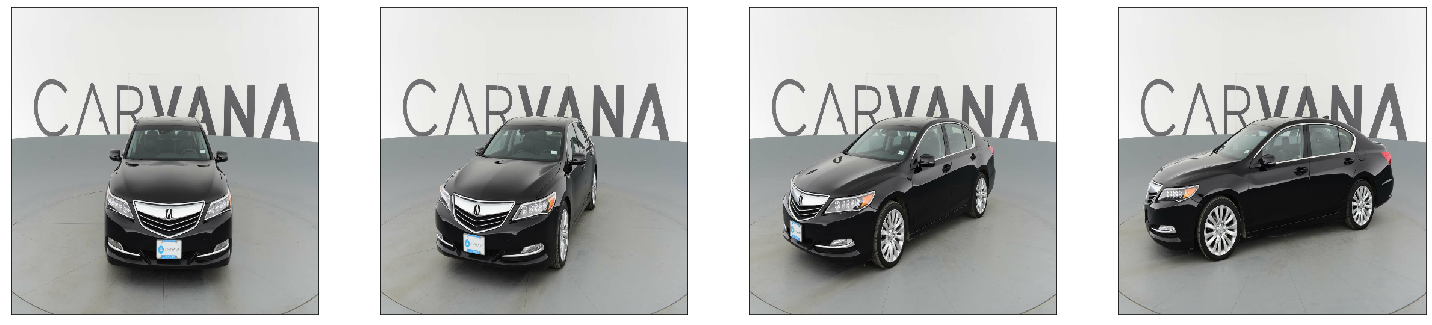

In [14]:
image_top = dataset_train_images.batch(4).__iter__()
image_top = next(image_top)
fig = plot_image_grid([image_top.numpy()], transpose=True)

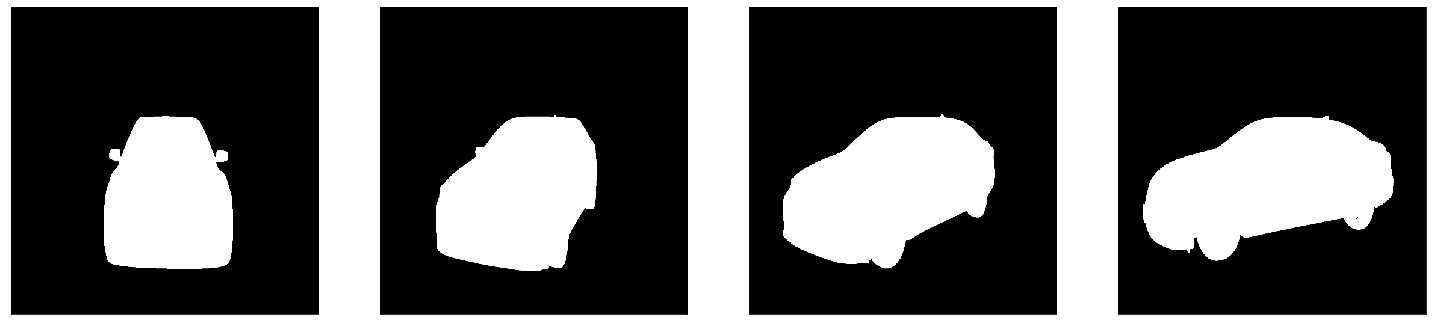

In [15]:
mask_top = dataset_train_masks.batch(4).__iter__()
mask_top = next(mask_top)
fig = plot_image_grid([mask_top.numpy()], transpose = True)

In [16]:
from tqdm import tqdm

In [17]:
gif_files = os.listdir(os.path.join(data_dir, 'train_masks'))

In [19]:
with tqdm(total = len(gif_files), position=0, leave=True) as pbar:
    for gif in tqdm(gif_files, position=0, leave=True):
        image_bytes = tf.io.read_file(os.path.join(data_dir, 'train_masks', gif))
        image = tf.io.decode_gif(image_bytes)
        image_squeezed = tf.squeeze(image)
        image_stacked = tf.unstack(image_squeezed, axis=-1)
        image = image_stacked[0]
        image_shape = image.shape + 1
        image = tf.reshape(image, (image_shape))
        image = tf.io.encode_jpeg(image, quality=100)
        tf.io.write_file(os.path.join(data_dir, 'pp_train_masks', gif.replace('.gif','.jpg')), image)
        pbar.update()

100%|██████████| 5088/5088 [02:42<00:00, 31.23it/s]


In [20]:
train_images = tf.data.Dataset.list_files(os.path.join(data_dir, 'train', '*.jpg'), shuffle = False)
train_masks = tf.data.Dataset.list_files(os.path.join(data_dir, 'pp_train_masks', '*.jpg'), shuffle = False)

In [21]:
parse_shape = (512,512)

def parse_train_images(filename):
    image_bytes = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size = parse_shape)
    return image

def parse_train_masks(filename):
    image_bytes = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image_bytes, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size = parse_shape)
    return image

In [22]:
dataset_train_images = train_images.map(parse_train_images, num_parallel_calls=4)
dataset_train_masks = train_masks.map(parse_train_masks, num_parallel_calls=4)

In [23]:
dataset_train_images, dataset_train_masks

(<ParallelMapDataset shapes: (512, 512, 3), types: tf.float32>,
 <ParallelMapDataset shapes: (512, 512, 1), types: tf.float32>)

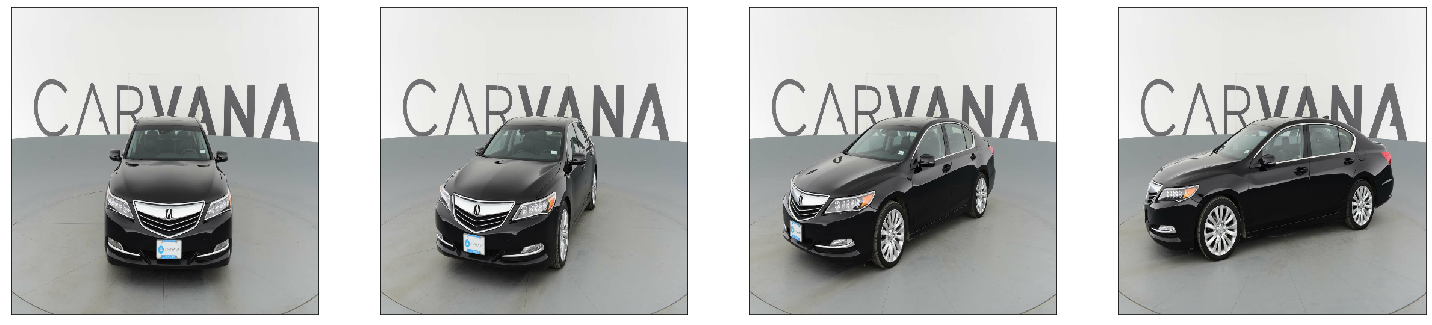

In [24]:
image_top = dataset_train_images.batch(4).__iter__()
image_top = next(image_top)
fig = plot_image_grid([image_top.numpy()], transpose=True)

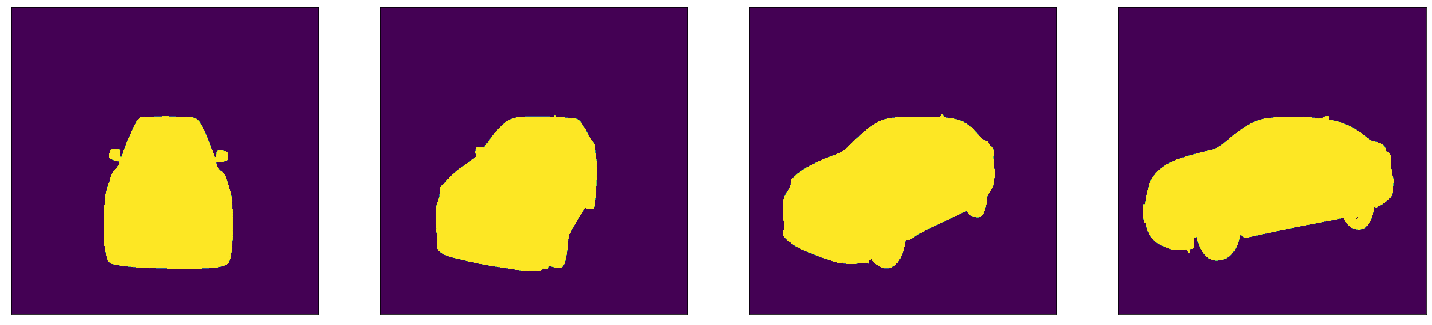

In [26]:
mask_top = dataset_train_masks.batch(4).__iter__()
mask_top = next(mask_top)
fig = plot_image_grid([mask_top.numpy().reshape(-1,512,512)], transpose=True)

In [27]:
dataset_train_images = dataset_train_images.prefetch(1)
dataset_train_masks = dataset_train_masks.prefetch(1)

In [28]:
options = tf.data.Options()

In [29]:
options.experimental_optimization.map_fusion = True
options.experimental_optimization.map_parallelization = True
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.apply_default_optimizations = True

dataset_train_images = dataset_train_images.with_options(options)
dataset_train_masks = dataset_train_masks.with_options(options)

In [30]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [31]:
def _image_as_bytes_feature(image):
    if image.dtype != tf.uint8:
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    image_string = tf.io.encode_jpeg(image, quality=100)
    return _bytes_feature(image_string)

In [36]:
def convert_sample_to_example(image, mask):
    features = tf.train.Features(feature={
        'image': _image_as_bytes_feature(image),
        'mask': _image_as_bytes_feature(mask),
    })
    
    example = tf.train.Example(features=features)
    return example

In [37]:
sample = next(dataset_train_images.__iter__())
sample2 = next(dataset_train_masks.__iter__())
example = convert_sample_to_example(sample, sample2)

In [38]:
example

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\002\000\002\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\0

In [39]:
tfrecord_file = os.path.join('.','unaugumented_image_mask.tfrecords')

num_samples = 0
with tf.io.TFRecordWriter(tfrecord_file) as writer:
    for image, mask in zip(dataset_train_images, dataset_train_masks):
        example = convert_sample_to_example(image, mask)
        writer.write(example.SerializeToString())
        num_samples += 1
        if num_samples % 1000 == 0:
            print(num_samples)
print(num_samples)

1000
2000
3000
4000
5000
5088


In [40]:
dataset = tf.data.TFRecordDataset(tfrecord_file)

In [41]:
def convert_example_to_sample(example):
    features_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    sample = tf.io.parse_single_example(example, features_description)
    sample['image'] = tf.io.decode_jpeg(sample['image'])
    sample['mask'] = tf.io.decode_jpeg(sample['mask'])
    return sample

In [42]:
dataset = dataset.map(convert_example_to_sample)

In [43]:
dataset_top = dataset.batch(4).__iter__()
dataset_top = next(dataset_top)

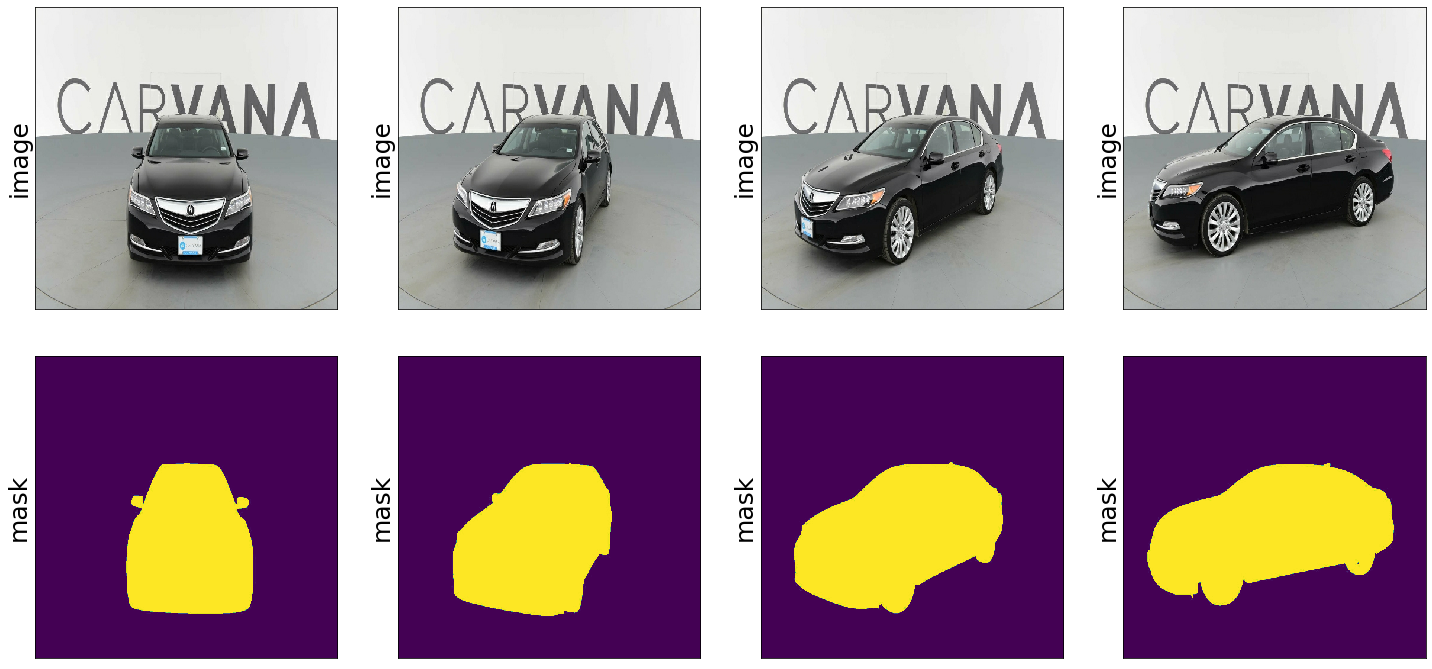

In [49]:
fig = plot_image_grid([dataset_top['image'].numpy(), dataset_top['mask'].numpy().reshape(-1,512,512)], 
                      titles=['image','mask'], transpose=True)